In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
if (torch.cuda.is_available()):
  device = torch.device("cuda")
  print(device, torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print(device)

cpu


### This notebook will be follow this guide line

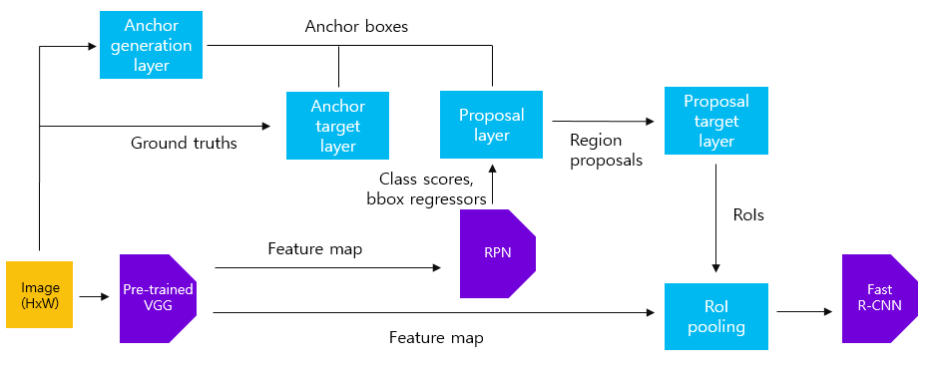

# 1) Define Sample Image

### Load sample image with GroundTruth

In [ ]:
GREEN_COLOR = (0,255,0)

normal_img = cv2.imread('/content/zoo.png')
boxes = np.array([[0, 80, 100, 135], [130, 80, 220, 130]])
labels = np.array([1,1])

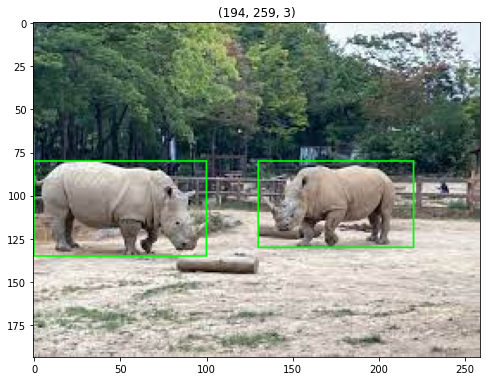

In [ ]:
rgb_normal_img = cv2.cvtColor(normal_img, cv2.COLOR_BGR2RGB)

draw_img = rgb_normal_img.copy()

for box in boxes:
  cv2.rectangle(draw_img, (box[0],box[1]), (box[2],box[3]), color=GREEN_COLOR, thickness=1)
plt.figure(figsize=(8,8))
plt.imshow(draw_img)
plt.title(draw_img.shape)
plt.show()

### Resize image and GroundTruth

In [ ]:
# Resize image
img = cv2.resize(rgb_normal_img, dsize=(800,800), interpolation=cv2.INTER_CUBIC)

In [ ]:
width_ratio = 800/rgb_normal_img.shape[1]
height_ratio = 800/rgb_normal_img.shape[0]
print("width_rartio: {}\nheight_ration: {}".format(width_ratio, height_ratio))

GroundTruth = []
for box in boxes:
  x1 = int(box[0] * width_ratio)
  y1 = int(box[1] * height_ratio)
  x2 = int(box[2] * width_ratio)
  y2 = int(box[3] * height_ratio)

  GroundTruth.append([x1,y1,x2,y2])

GroundTruth = np.array(GroundTruth)
print(GroundTruth)

width_rartio: 3.088803088803089
height_ration: 4.123711340206185
[[  0 329 308 556]
 [401 329 679 536]]


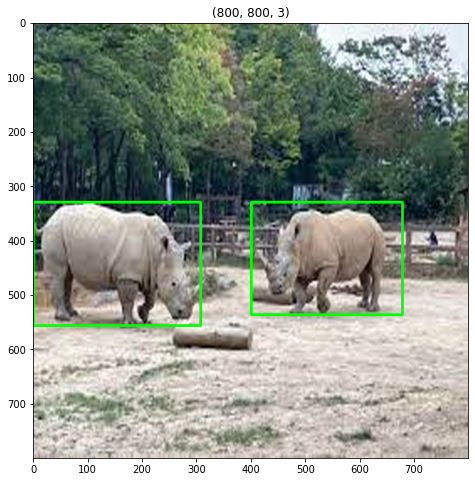

In [ ]:
draw_img = img.copy()

for box in GroundTruth:
  cv2.rectangle(draw_img, (box[0],box[1]), (box[2],box[3]), color=GREEN_COLOR, thickness=3)
plt.figure(figsize=(8,8))
plt.imshow(draw_img)
plt.title(draw_img.shape)
plt.show()

# 2) Load BackBone model (VGG16)

In [ ]:
model = torchvision.models.vgg16(pretrained=True).to(device)
features = list(model.features)

## 원본 모델 layers
for feature in features:
  print(feature)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=Tru

In [ ]:
dummy_img = torch.zeros((1,3,800,800)).float()
print("Dummy img shape: {}".format(dummy_img.shape))

req_features = []
output = dummy_img.clone().to(device) # 이미지 복사

for feature in features:
  output = feature(output)

  if output.shape[2] < 800//16:
    break
  req_features.append(feature)
  out_channels = output.shape[1]

print("Last geatures maps channle size : {}".format(out_channels))
faster_rcnn_feature_extractor = nn.Sequential(*req_features)

Dummy img shape: torch.Size([1, 3, 800, 800])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Last geatures maps channle size : 512


### Input sample image to the backbone model

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)

output_map = faster_rcnn_feature_extractor(imgTensor)
print("Output size : {}".format(output_map.shape))

Output size : torch.Size([1, 512, 50, 50])


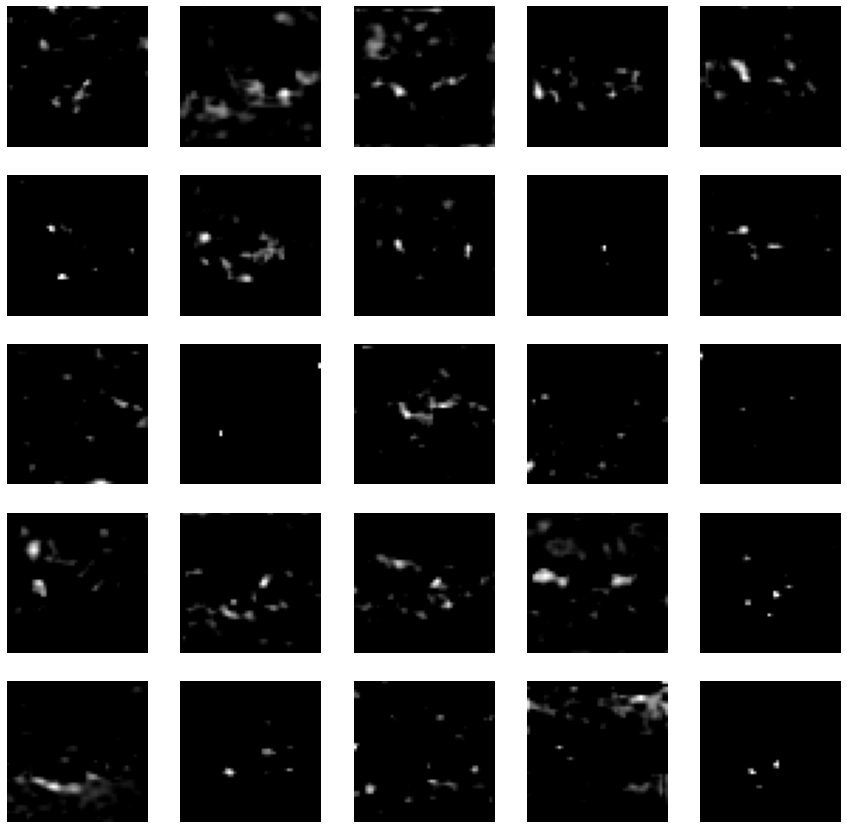

In [ ]:
# Visualizing the feature maps
img_array = output_map.data.cpu().numpy().squeeze(0)

fig , axes = plt.subplots(5, 5, figsize=(15,15))

x_idx = 0
y_idx = 0

for i in range(5*5):
    if x_idx == 5:
        x_idx = 0
        y_idx += 1
        
    axes[y_idx][x_idx].imshow(img_array[i], 'gray')
    axes[y_idx][x_idx].axis("off")
    x_idx += 1

plt.show()

# 3) Anchor generate layer
### Generate Anchor dots

In [ ]:
feature_size = 800/16
print("Feature maps size : {}".format(feature_size))

center_x = np.arange(16, (feature_size+1)*16, 16)
center_y = np.arange(16, (feature_size+1)*16, 16)
print(len(center_x))
print(center_x)

Feature maps size : 50.0
50
[ 16.  32.  48.  64.  80.  96. 112. 128. 144. 160. 176. 192. 208. 224.
 240. 256. 272. 288. 304. 320. 336. 352. 368. 384. 400. 416. 432. 448.
 464. 480. 496. 512. 528. 544. 560. 576. 592. 608. 624. 640. 656. 672.
 688. 704. 720. 736. 752. 768. 784. 800.]


In [ ]:
index = 0
center = np.zeros((2500,2))

for i in range(len(center_x)):
  for j in range(len(center_y)):
    center[index, 0] = center_x[i] - 8
    center[index, 1] = center_y[j] - 8
    index += 1
print("Center Shape: {}".format(center.shape))
print(center[:10])

Center Shape: (2500, 2)
[[  8.   8.]
 [  8.  24.]
 [  8.  40.]
 [  8.  56.]
 [  8.  72.]
 [  8.  88.]
 [  8. 104.]
 [  8. 120.]
 [  8. 136.]
 [  8. 152.]]


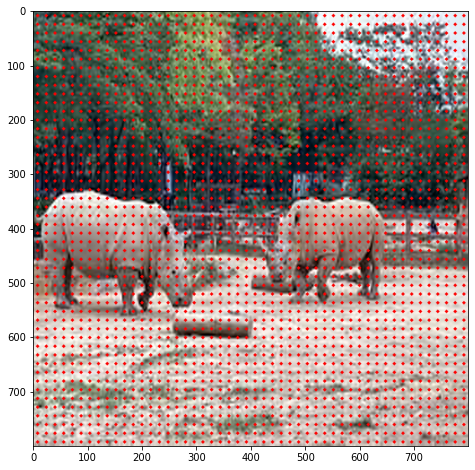

In [ ]:
img_test1 = img.copy()
center_int = center.astype("int32")

for o in center_int:
  cv2.circle(img_test1, (o[0],o[1]), radius=1,
             color=(255,0,0), thickness=3)

plt.figure(figsize=(8,8))
plt.imshow(img_test1)
plt.show()

### Generate Anchor boxes

In [ ]:
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_smaple = 16
feature_size = 800//16

anchor_boxes = np.zeros(((feature_size* feature_size * 9),4))
index = 0

for c in center:
  sam_center_x, sam_center_y = c
  for ratio in ratios:
    for scale in scales:

      h = sub_smaple * scale * np.sqrt(ratio)
      w = sub_smaple * scale * np.sqrt(1./ratio)

      anchor_boxes[index, 0] = sam_center_x - w/2
      anchor_boxes[index, 1] = sam_center_y - h/2
      anchor_boxes[index, 2] = sam_center_x + w/2
      anchor_boxes[index, 3] = sam_center_y + h/2
      index += 1

print("Anchor boexes shape {}".format(anchor_boxes.shape))
print(anchor_boxes[:10])
      

Anchor boexes shape (22500, 4)
[[ -82.50966799  -37.254834     98.50966799   53.254834  ]
 [-173.01933598  -82.50966799  189.01933598   98.50966799]
 [-354.03867197 -173.01933598  370.03867197  189.01933598]
 [ -56.          -56.           72.           72.        ]
 [-120.         -120.          136.          136.        ]
 [-248.         -248.          264.          264.        ]
 [ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 [ -82.50966799  -21.254834     98.50966799   69.254834  ]]


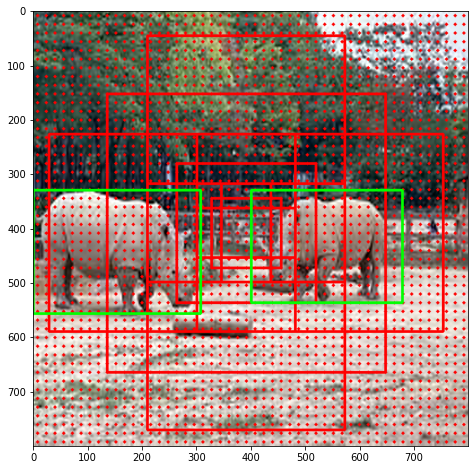

In [ ]:
img_test = img.copy()
center_int = center.astype("int32")

for o in center_int:
  cv2.circle(img_test, (o[0],o[1]), radius=1,
             color=(255,0,0), thickness=3)

for i in range(11025, 11034):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    cv2.rectangle(img_test, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)
    
for box in GroundTruth:
  cv2.rectangle(img_test, (box[0],box[1]), (box[2],box[3]), color=GREEN_COLOR, thickness=3)

plt.figure(figsize=(8,8))
plt.imshow(img_test)
plt.show()

# 4) Anchor target layer

### Choose Anchor boxes inside the image

In [ ]:
index_inside = np.where(
    (anchor_boxes[:, 0] >=0) &
    (anchor_boxes[:, 1] >=0) &
    (anchor_boxes[:, 2] <=800) &
    (anchor_boxes[:, 3] <=800))[0]

print("index_inside shpae: {}".format(index_inside.shape))
valid_anchor_boxes = anchor_boxes[index_inside]
print("valid_anchor_boxes shape: {}".format(valid_anchor_boxes.shape))
print(valid_anchor_boxes[:10])

index_inside shpae: (8940,)
valid_anchor_boxes shape: (8940, 4)
[[ 10.745166    13.49033201 101.254834   194.50966799]
 [ 10.745166    29.49033201 101.254834   210.50966799]
 [ 10.745166    45.49033201 101.254834   226.50966799]
 [ 10.745166    61.49033201 101.254834   242.50966799]
 [ 10.745166    77.49033201 101.254834   258.50966799]
 [ 10.745166    93.49033201 101.254834   274.50966799]
 [ 10.745166   109.49033201 101.254834   290.50966799]
 [ 10.745166   125.49033201 101.254834   306.50966799]
 [ 10.745166   141.49033201 101.254834   322.50966799]
 [ 10.745166   157.49033201 101.254834   338.50966799]]


### Calculate IOU

In [ ]:
# GT값들과 Anchorbox들과의 IOU를 구하는 단계
ious = np.zeros((valid_anchor_boxes.shape[0],2), dtype=np.float32)

# anchor boxes
# 이미지 사이즈 (800.800)내의 이미지들만을 가지고 값을 계산
for i, anchor_box in enumerate(valid_anchor_boxes):
  xa1,ya1,xa2,ya2 = anchor_box
  anchor_area = (xa2-xa1) * (ya2-ya1)

    # ground truth boxes
  for j, gt_box in enumerate(GroundTruth):
    xb1, yb1, xb2, yb2 = gt_box
    box_area = (xb2 - xb1) * (yb2 - yb1)

    inter_x1 = max([xb1, xa1])
    inter_y1 = max([yb1, ya1])
    inter_x2 = min([xb2, xa2])
    inter_y2 = min([yb2, ya2])

    if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
      inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
      iou = inter_area / (anchor_area + box_area - inter_area)
    else:
      iou = 0
    
    ious[i,j] = iou

print("ious shape: {}".format(ious.shape))
print(ious[5000:5010, :])

ious shape: (8940, 2)
[[0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.00177499 0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]


### Sample POS/NEG Anchor boxes

In [ ]:
# GroundTruth들과 IOU가 가장 큰 값의 인덱스들 (GroundTruth가 2개라면 값은 2개가 나옴)
gt_argmax_ious = ious.argmax(axis=0)
print("gt_argmax_ious Indexs : \n{}".format(gt_argmax_ious))

# GroundTruth들과 IOU가 가장 큰 값
gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print("\ngt_max_ious Values : \n{}".format(gt_max_ious))

# GroundTruth들과 IOU가 가장 큰 값과 같은 값들을 갖는 인덱스들
gt_max_ious = np.where(ious == gt_max_ious)[0]
print("\ngt_max_ious Indexs : \n{}".format(gt_max_ious))

gt_argmax_ious Indexs : 
[ 607 6620]

gt_max_ious Values : 
[0.7513835 0.7560565]

gt_max_ious Indexs : 
[ 607  612  793  798  979  984 6620 6628 6636 6643]


In [ ]:
# Anchor box와 IOU를 갖는 GroundTruth를 구해주는 셀

# 그중에 인덱스를 구해줌
argmax_ious = ious.argmax(axis=1)
print("argmax_ious shape : \n{}".format(argmax_ious.shape))
print("argmax_ious Indexs : \n{}".format(argmax_ious[4000:4100]))

# 인덱스를 바탕으로 값을 구해줌
max_ious = ious[np.arange(ious.shape[0]), argmax_ious]
print("\nmax_ious shape : \n{}".format(max_ious.shape))
print("max_ious Values : \n{}".format(max_ious[4000:4100]))

argmax_ious shape : 
(8940,)
argmax_ious Indexs : 
[1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1]

max_ious shape : 
(8940,)
max_ious Values : 
[0.07557705 0.01097827 0.07863175 0.1508419  0.01662518 0.08636592
 0.17587991 0.01600833 0.08551988 0.02567966 0.10275615 0.16991752
 0.02542408 0.10240128 0.17587991 0.02055362 0.09564826 0.04081492
 0.12798436 0.18963619 0.03437662 0.1189171  0.17587991 0.02513975
 0.10596742 0.05640355 0.15439391 0.21003094 0.04348685 0.13593532
 0.17587991 0.02976729 0.1164828  0.07246623 0.18206976 0.23113717
 0.05275899 0.15347922 0.17587991 0.0344368  0.12381589 0.08719403
 0.21110523 0.2515773  0.06219738 0.17157352 0.17587991 0.03914885
 0.12381589 0.11237536 0.08719403 0.24160303 0.2515773  0.07180654
 0.19024456 0.17587991 0.04390402 0.12381589 0.11237536 0.08719403
 0.27367648 0.2515773  0.0724

In [ ]:
# 인덱스 바탕로 GroundTruth를 정해줌

label = np.zeros_like(index_inside)
label.fill(-1)
print("Label shape: {}".format(label.shape))
print("Label Values: {}".format(label[:10]))

Label shape: (8940,)
Label Values: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [ ]:
# IOU가 가장 큰 값들 POS
# IOU가 0.7이상이면 POS / 0.3 이하면 NEG
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

# label 변수에 위의 정의 된 변수들 바탕으로 값을 담아줌
label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

print("Label shape: {}".format(label.shape))
print("Label Values: {}".format(label[6000:6100]))

Label shape: (8940,)
Label Values: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1  0  0 -1  0
 -1  0 -1  0]


In [ ]:
# 1BATCH = 256 SAMPLES(128 POS/128 NEG)
# 만약 POS/NEG값이 256을 넘으면 랜덤리하게 몇몇의 값을 -1로 변환시켜서 무시ㅎ
n_samples = 256

# 128 POSITIVE
pos_ratio = 0.5
n_pos = pos_ratio * n_samples

pos_index = np.where(label==1)[0]
if len(pos_index) > n_pos:
  disable_index = np.random.choice(pos_index,
                                  size=(len(pos_index) - n_pos),
                                  replace=False)
  label[disable_index] = -1

# 128 NEGATIVE
n_neg = n_samples * np.sum(label == 1)

neg_index = np.where(label == 0)
if len(neg_index) > n_neg:
  disable_index = np.random.choice(pos_index,
                                  size=(len(neg_index) - n_neg),
                                  replace=False)
  label[disable_index] = -1

### Define target values
* anchor 박스의 값을 밑의 그림과 같이 변환해줌

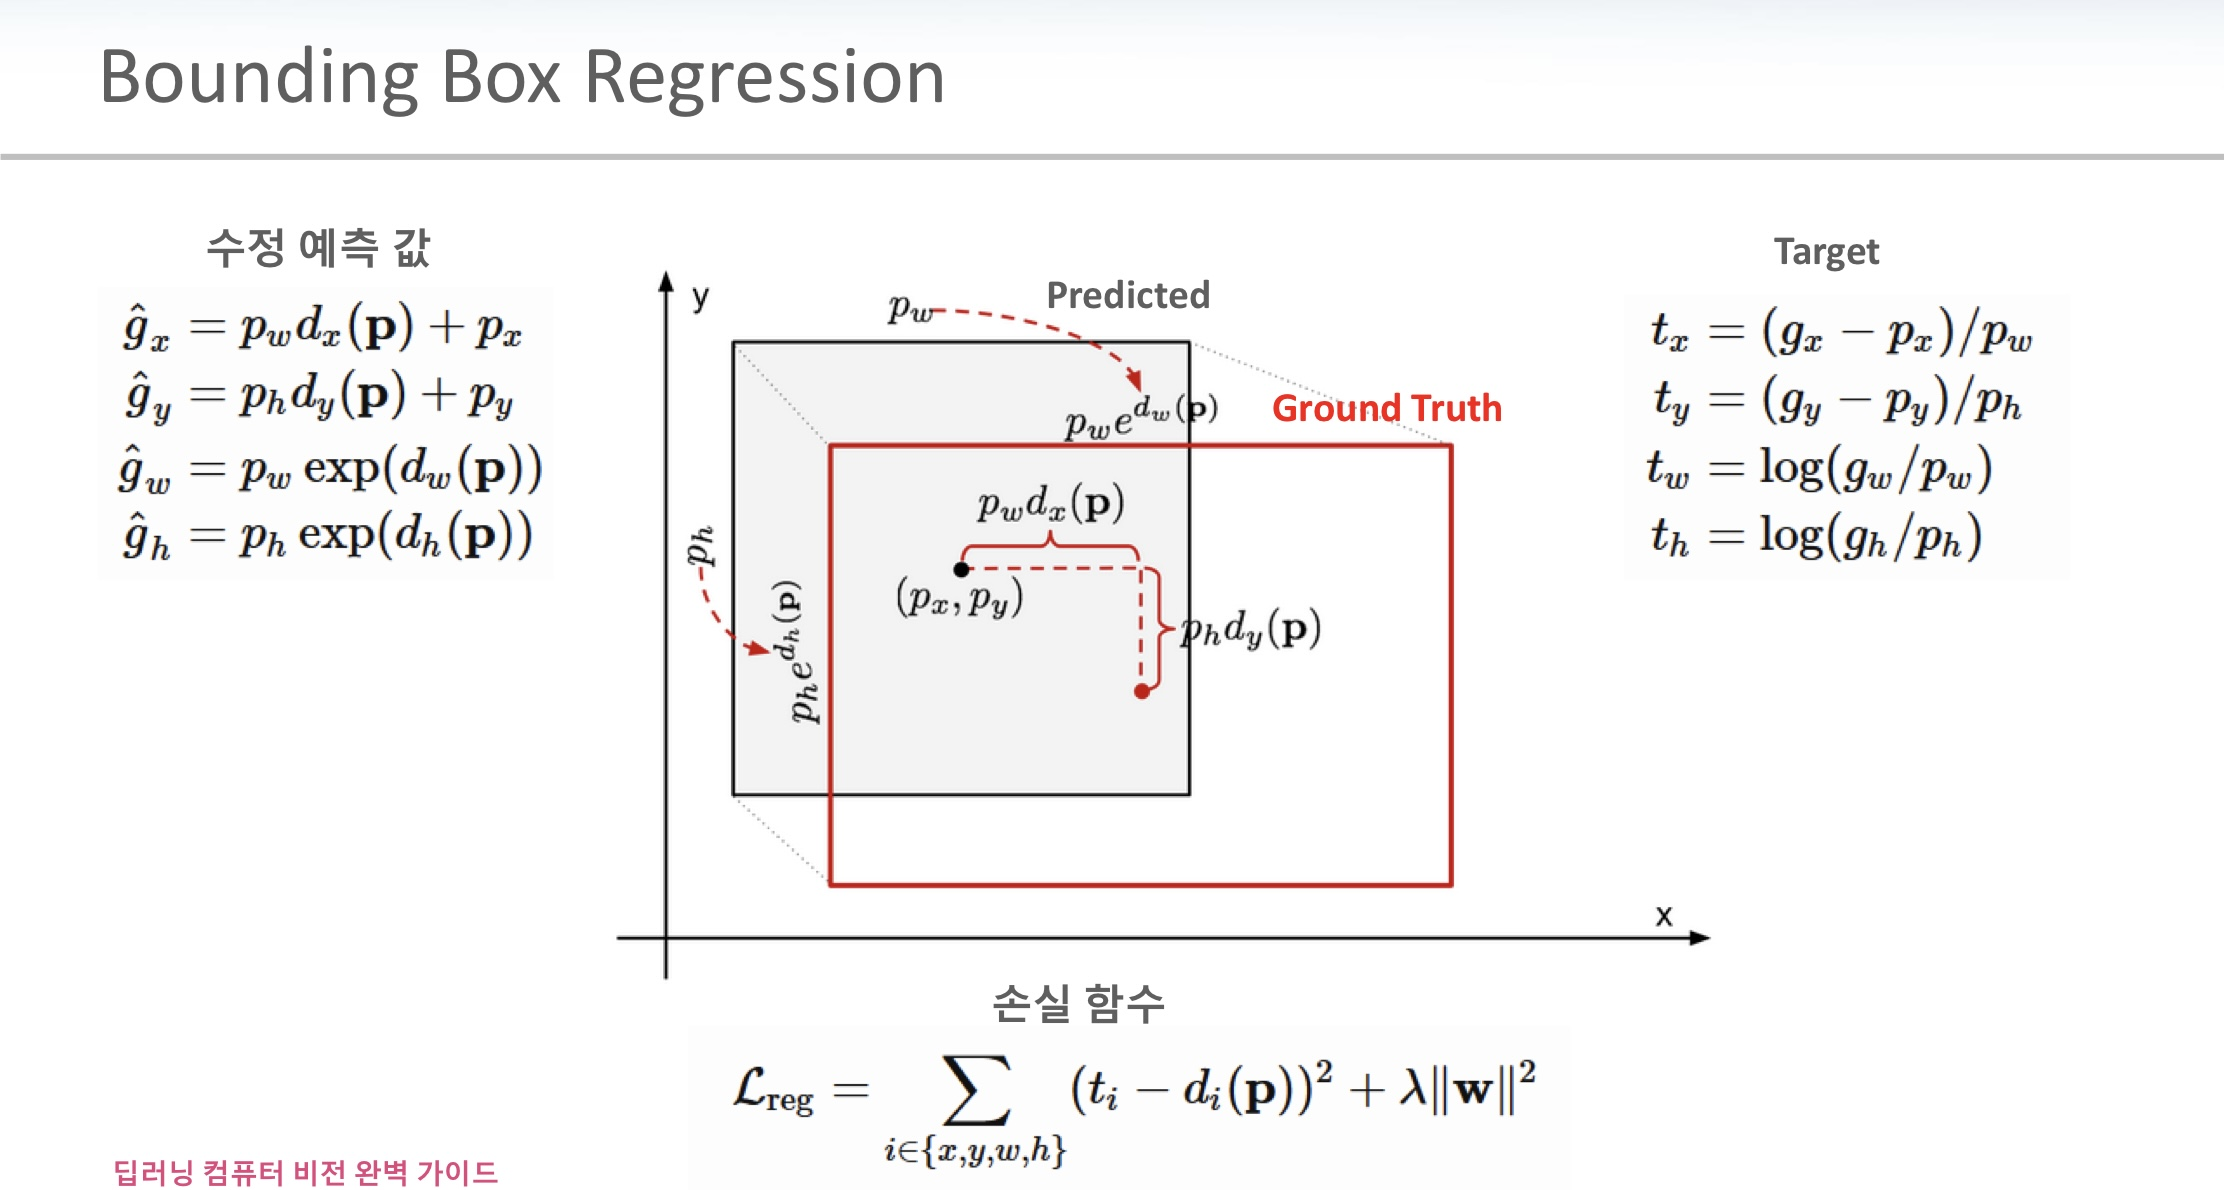

In [ ]:
# 22500개의 앵커 박스중에서 이미지 속에 해당하는 8940개의 앵커박스를 [x, y, w, h] 형태로 변환해줌
# 그 이후 LABEL

max_iou_bbox =  GroundTruth[argmax_ious]
print("max_iou_bbox shape: {}".format(max_iou_bbox.shape))
print("max_iou_bbox Values: \n{}".format(max_iou_bbox[:5]))

# 기본 앵커 박스들
height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
width = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
center_y = valid_anchor_boxes[:, 1] + 0.5 * height
center_x = valid_anchor_boxes[:, 0] + 0.5 * width

# GroundTruth를
target_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
target_width = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
target_center_y = max_iou_bbox[:, 1] + 0.5 * target_height
target_center_x = max_iou_bbox[:, 0] + 0.5 * target_width

# 앵커박스들을 Proposal Layer에 넣기위해 값 연
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (target_center_y - center_y) / height
dx = (target_center_x - center_x) / width
dh = np.log(target_height / height)
dw = np.log(target_width / width)

anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
print("\nanchor_locs shape: {}".format(anchor_locs.shape))
print("max_iou_bbox Values: \n{}".format(anchor_locs[:5]))

max_iou_bbox shape: (8940, 4)
max_iou_bbox Values: 
[[  0 329 308 556]
 [  0 329 308 556]
 [  0 329 308 556]
 [  0 329 308 556]
 [  0 329 308 556]]

anchor_locs shape: (8940, 4)
max_iou_bbox Values: 
[[1.08275726 1.86996598 1.22464311 0.22634616]
 [1.08275726 1.78157763 1.22464311 0.22634616]
 [1.08275726 1.69318928 1.22464311 0.22634616]
 [1.08275726 1.60480094 1.22464311 0.22634616]
 [1.08275726 1.51641259 1.22464311 0.22634616]]


### Final define "Label"/"Anchor Boxes"

In [ ]:
# 22500개의 앵커박스를 대상으로 label을 다시 선언함
anchor_labels = np.zeros((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print("anchor_labels shape: {}".format(anchor_labels.shape))
print("anchor_labels Values: \n{}".format(anchor_labels[:5]))

# 22500개의 앵커박스를 대상으로 loaction을 다시 선언함
anchor_locations = np.zeros((len(anchor_boxes),4), dtype=anchor_locs.dtype)
anchor_locations[index_inside] = anchor_locs
print("\nanchor_locations shape: {}".format(anchor_locations.shape))
print("anchor_locations Values: \n{}".format(anchor_locations[:5]))

anchor_labels shape: (22500,)
anchor_labels Values: 
[-1 -1 -1 -1 -1]

anchor_locations shape: (22500, 4)
anchor_locations Values: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


#5) RPN (Region Proposal Network)

In [ ]:
IN_CHANNLES = 512
MID_CHANNELS = 512
N_ANCHORS = 9

In [ ]:
conv1 = nn.Conv2d(IN_CHANNLES, MID_CHANNELS, 3 ,1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

# bounding box regressor
reg_layer = nn.Conv2d(MID_CHANNELS, N_ANCHORS * 4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

# classifier(object or not)
cls_layer = nn.Conv2d(MID_CHANNELS, N_ANCHORS * 2, 1, 1, 0).to(device)
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Inference it

In [ ]:
# Do inference
x = conv1(output_map.to(device))

pred_cls_scores = cls_layer(x) # classifier output
pred_anchor_locs = reg_layer(x) # bounding box regresor output

print("pred_anchor_locs shape: {}".format(pred_anchor_locs.shape))
print("pred_cls_scores shape: {}".format(pred_cls_scores.shape))

pred_anchor_locs shape: torch.Size([1, 36, 50, 50])
pred_cls_scores shape: torch.Size([1, 18, 50, 50])


In [ ]:
# 원본 앵커들과 loss값을 구해야하기에 모양에 맞게 flatten해줌
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print("pred_anchor_locs shape: {}".format(pred_anchor_locs.shape))

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print("objectness_score shape: {}".format(objectness_score.shape))
pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print("pred_cls_scores shape: {}".format(pred_cls_scores.shape))

pred_anchor_locs shape: torch.Size([1, 22500, 4])
objectness_score shape: torch.Size([1, 22500])
pred_cls_scores shape: torch.Size([1, 22500, 2])


In [ ]:
# calculate the RPN loss¶

print("pred_anchor_locs shape: {}".format(pred_anchor_locs.shape))
print("pred_anchor_locs Values: \n{}".format(pred_anchor_locs[:5]))

print("\npred_cls_scores shape: {}".format(pred_cls_scores.shape))
print("pred_cls_scores Values: \n{}".format(pred_cls_scores[:5]))

print("\nanchor_locations shape: {}".format(anchor_locations.shape))
print("anchor_locations Values: \n{}".format(anchor_locations[:5]))

print("\nanchor_labels shape: {}".format(anchor_labels.shape))
print("anchor_labels Values: \n{}".format(anchor_labels[:5]))

pred_anchor_locs shape: torch.Size([1, 22500, 4])
pred_anchor_locs Values: 
tensor([[[-0.0198, -0.0290,  0.0108, -0.0091],
         [ 0.0281, -0.0322,  0.0275,  0.0136],
         [-0.0377, -0.0016,  0.0212, -0.0148],
         ...,
         [-0.0121,  0.0032,  0.0040, -0.0163],
         [-0.0427, -0.0302, -0.0248,  0.0305],
         [-0.0124,  0.0236, -0.0572,  0.0228]]], grad_fn=<SliceBackward>)

pred_cls_scores shape: torch.Size([1, 22500, 2])
pred_cls_scores Values: 
tensor([[[-0.0225,  0.0595],
         [ 0.0030,  0.0200],
         [ 0.0152,  0.0031],
         ...,
         [ 0.0027, -0.0199],
         [ 0.0257,  0.0021],
         [-0.0111, -0.0518]]], grad_fn=<SliceBackward>)

anchor_locations shape: (22500, 4)
anchor_locations Values: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

anchor_labels shape: (22500,)
anchor_labels Values: 
[-1 -1 -1 -1 -1]


In [ ]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print("rpn_loc shape: {}".format(rpn_loc.shape))
print("rpn_score shape: {}".format(rpn_score.shape))
print("\ngt_rpn_loc shape: {}".format(gt_rpn_loc.shape))
print("gt_rpn_score shape: {}".format(gt_rpn_score.shape))

rpn_loc shape: torch.Size([22500, 4])
rpn_score shape: torch.Size([22500, 2])

gt_rpn_loc shape: torch.Size([22500, 4])
gt_rpn_score shape: torch.Size([22500])


### Multi-task loss
* RPN에서의 loss값을 구하고 Train하는 과정
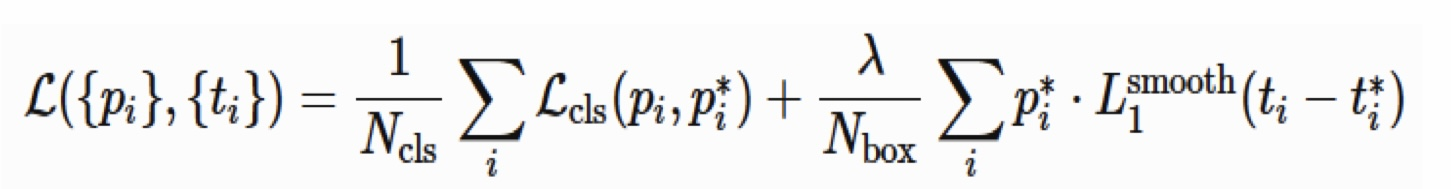

In [ ]:
# Classification Loss
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(device),
                               ignore_index = -1)
print("rpn_cls_loss Values: {}".format(rpn_cls_loss))

rpn_cls_loss Values: 0.6959484219551086


In [ ]:
# Regressor Loss
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print("mask shape: {}".format(mask.shape))

mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print("\nmask_loc_preds shape: {}".format(mask_loc_preds.shape))
print("mask mask_loc_targets: {}".format(mask_loc_targets.shape))

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print("\nrpn_loc_loss Values: {}".format(rpn_loc_loss.sum()))

mask shape: torch.Size([22500, 4])

mask_loc_preds shape: torch.Size([24, 4])
mask mask_loc_targets: torch.Size([24, 4])

rpn_loc_loss Values: 0.8812874020149142


In [ ]:
# Combining both the rpn_cls_loss and rpn_reg_loss
# RPN Loss

rpn_lambda = 10
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print("rpn_loss Valuse: {}".format(rpn_loss))

rpn_loss Valuse: 1.0631515061279897


# 6) Proposal Layer

### Tranfrom Anchor boxes (NMS)

In [ ]:
nms_thresh = 0.7  # non-maximum supression (NMS) 
n_train_pre_nms = 12000 # no. of train pre-NMS
n_train_post_nms = 2000 # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms = 6000
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

In [ ]:
# 22500개의 모든 앵커박스들의 포맷을 [x,y,w,h]로 변환해줌

print("anchor_boxes shape: {}".format(anchor_boxes.shape))
anc_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_ctr_y = anchor_boxes[:, 1] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 0] + 0.5 * anc_width

anchor_boxes shape: (22500, 4)


In [ ]:
# 예측해서 나온 Anchor box들의 값은 이미 앵커박스 화 돼있음 
# [dx, dy, dw, dh]
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()

dy = pred_anchor_locs_numpy[:, 1::4]
dx = pred_anchor_locs_numpy[:, 0::4]
dh = pred_anchor_locs_numpy[:, 3::4]
dw = pred_anchor_locs_numpy[:, 2::4]

print(dy.shape)
print(dx.shape)
print(dh.shape)
print(dw.shape)

(22500, 1)
(22500, 1)
(22500, 1)
(22500, 1)


### 아래 그림을 바탕으로 예측된 값들을 실제화로 변환 시킴

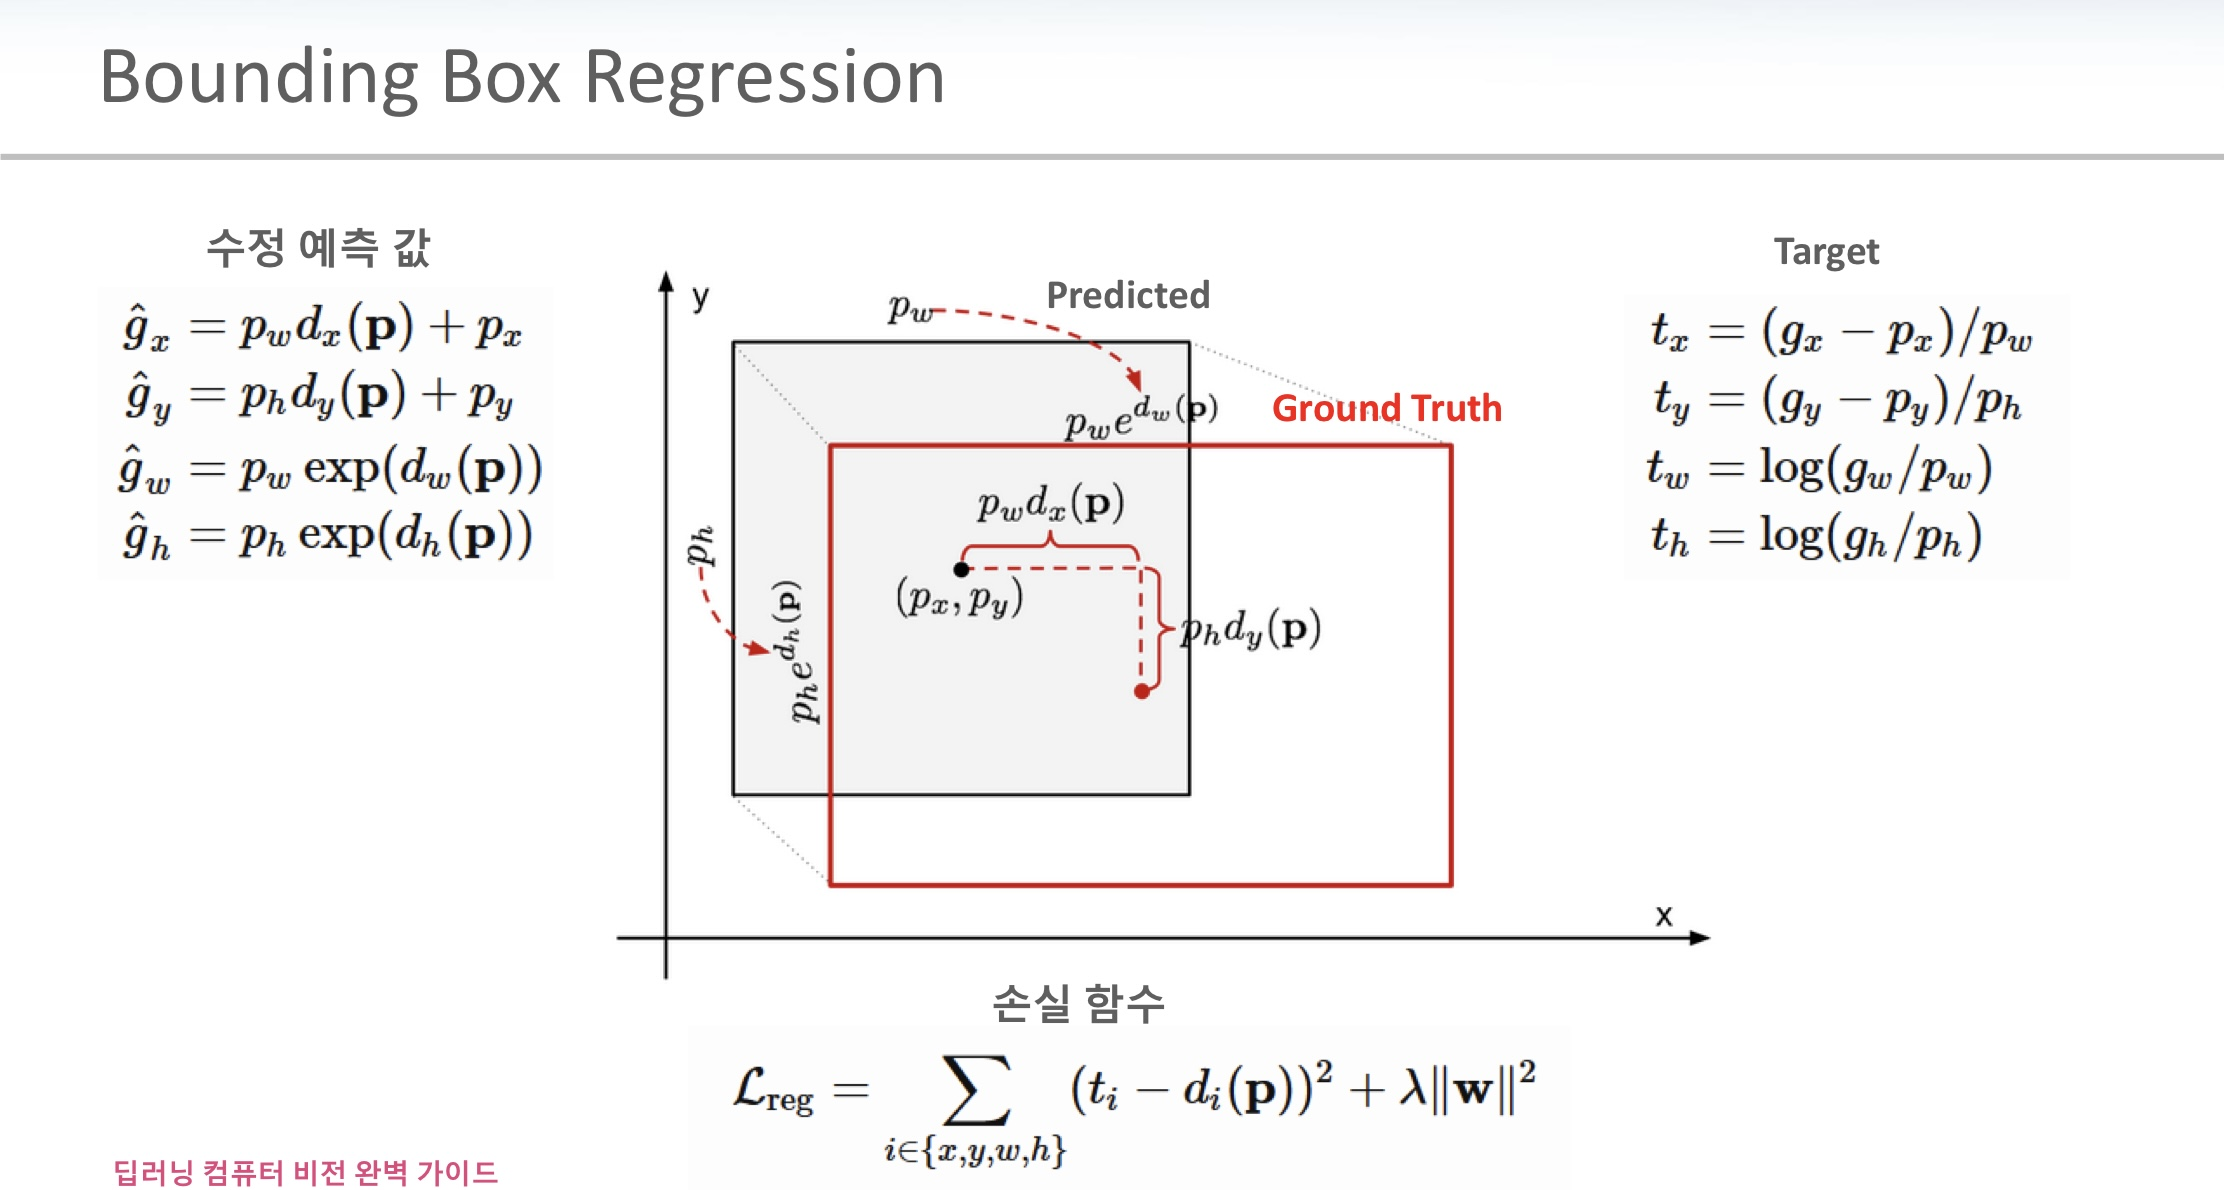

In [ ]:
# 예측된 값을 실제화로 변환하고 이를 roi변수에 담음
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]

print(ctr_y.shape)
print(ctr_x.shape)
print(h.shape)
print(w.shape)

roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_x - 0.5 * w
roi[:, 1::4] = ctr_y - 0.5 * h
roi[:, 2::4] = ctr_x + 0.5 * w
roi[:, 3::4] = ctr_y + 0.5 * h

print("\nroi shape: {}".format(roi.shape))
print("roi Values: {}".format(roi))

(22500, 1)
(22500, 1)
(22500, 1)
(22500, 1)

roi shape: (22500, 4)
roi Values: [[ -87.07154476  -39.46555404   95.9117993    50.22383512]
 [-167.90780126  -89.57771944  204.23731004   93.91948979]
 [-389.10750147 -170.94388018  350.50167769  185.7674733 ]
 ...
 [ 745.46817702  703.53239234  836.33771031  881.63298151]
 [ 695.98322045  594.44608513  872.56123618  967.71275307]
 [ 616.56747223  438.69149406  958.48346652 1179.46120187]]


### Clip the anchor boxes to the image

In [ ]:
# np.clip(arr, num1, num2) => arr에서 num1보다 작은 값은 num1으로 바꾸고 num2 보다 큰값을 num2로 바꿈
# slice(start, end, step)
# clip the predcited boxes to the image

img_size = (800, 800)
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0]) # [:, 0, 2]
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1]) # [:, 1, 3]

print("roi shape: {}\nMAX: {}\nMIN: {}".format(roi.shape, np.max(roi), np.min(roi)))

roi shape: (22500, 4)
MAX: 800.0
MIN: 0.0


In [ ]:
# 위에서 정한 min_size변수보다 크기가 큰것만 사용함
hs = roi[:, 3] - roi[:, 1]
ws = roi[:, 2] - roi[:, 0]

keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]

print("keep shape: {}".format(keep.shape))
print("roi shape: {}".format(roi.shape))
print("score shape: {}".format(score.shape))

keep shape: (22500,)
roi shape: (22500, 4)
score shape: (22500,)


### Select top 12000 anchor boxes by objectness score

In [ ]:
# 정렬하는 인덱스 찾기
order = score.ravel().argsort()[::-1]
print("order shape: {}".format(order.shape))
print("order Values: {}".format(order[:5]))

order shape: (22500,)
order Values: [13392 13401 13842 13851 14238]


In [ ]:
order = order[:n_train_pre_nms]
print("order shape: {}".format(order.shape))
print("order Values: {}".format(order[:5]))

roi = roi[order, :]
print("\nroi shape: {}".format(roi.shape))
print("roi Values: {}".format(roi[:5]))

order shape: (12000,)
order Values: [13392 13401 13842 13851 14238]

roi shape: (12000, 4)
roi Values: [[363.07772596 557.34935464 567.87842594 647.33945516]
 [353.47473579 589.55684191 572.73290804 675.71907529]
 [361.12660026 564.80712889 565.45257972 652.10009006]
 [349.09106528 591.63422117 568.2404137  675.99165771]
 [399.69469406 470.50642002 597.15598904 573.15666778]]


### NMS : Select top 2000 anchor boxes

In [ ]:
# take all the roi boxes
x1 = roi[:, 0]
y1 = roi[:, 1]
x2 = roi[:, 2]
y2 = roi[:, 3]

# find the areas of all the boxes

areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [ ]:
# take the indexes of order the probability score in descending order
# non maximum suppression

order = order.argsort()[::-1]
keep = []

while (order.size > 0):
  i = order[0] # take the 1st elt in roder and append to keep
  keep.append(i)

  xx1 = np.maximum(x1[i], x1[order[1:]])
  yy1 = np.maximum(y1[i], y1[order[1:]])
  xx2 = np.minimum(x2[i], x2[order[1:]])
  yy2 = np.minimum(y2[i], y2[order[1:]])

  w = np.maximum(0.0, xx2 - xx1 + 1)
  h = np.maximum(0.0, yy2 - yy1 + 1)

  inter = w * h
  ovr = inter / (areas[i] + areas[order[1:]] - inter)
  inds = np.where(ovr <= nms_thresh)[0]
  order = order[inds + 1]

keep = keep[:n_train_post_nms] # while training/testing, use accordingly
roi = roi[keep]
print(len(keep), roi.shape)

2000 (2000, 4)


# 7) Proposal Target Layer

### Calculate IOU

In [ ]:
n_sample = 128 # number of samples from roi
pos_ratio = 0.25 # number of positive examples out of the n_samples
pos_iou_thresh = 0.5 # min iou of region proposal with any ground truth object to consider it as positive label
neg_iou_thresh_hi = 0.5 # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [ ]:
# nms로 추출된 2000개의 값과 GroundTruth의 IOU를 구함
ious = np.zeros((len(roi), GroundTruth.shape[0]), dtype = np.float32)

for num1, i in enumerate(roi):
  ya1, xa1, ya2, xa2 = i
  anchor_area = (ya2 - ya1) * (xa2 - xa1)

  for num2, j in enumerate(GroundTruth):
    yb1, xb1, yb2, xb2 = j
    box_area = (yb2 - yb1) * (xb2 - xb1)
    inter_x1 = max([xb1, xa1])
    inter_y1 = max([yb1, ya1])
    inter_x2 = min([xb2, xa2])
    inter_y2 = min([yb2, ya2])

    if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
      inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
      iou = inter_area / (anchor_area + box_area - inter_area)
    else:
      iou = 0
    ious[num1, num2] = iou

print("ious shape: {}".format(ious.shape))
print("ious Values: {}".format(ious[:10]))

ious shape: (2000, 2)
ious Values: [[0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.07546012]]


In [ ]:
# GroundTruth와의 IOU를 바탕으로 인덱스와 그 값을 추출함
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)
print("gt_assignment Values: {}".format(gt_assignment[:10]))
print("max_iou Values: {}".format(max_iou[:10]))

# 2000개의 값이 가리키는 label이 뭔지를 추출
gt_roi_label = labels[gt_assignment]
print("\nlabels Values: {}".format(labels))
print("gt_roi_label Values: {}".format(gt_roi_label[:10]))

gt_assignment Values: [0 0 0 0 0 0 0 0 0 1]
max_iou Values: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.07546012]

labels Values: [1 1]
gt_roi_label Values: [1 1 1 1 1 1 1 1 1 1]


In [ ]:
# FOREGROUND
pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))

if pos_index.size > 0:
  pos_index = np.random.choice(
      pos_index, size=pos_roi_per_this_image, replace=False)
  
print(pos_roi_per_this_image)
print(pos_index)

12
[1063  621  696  825 1116 1334  892 1173 1062  946 1231  894]


In [ ]:
# BACKGROUND
neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                     (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))

if neg_index.size > 0:
  neg_index = np.random.choice(
    neg_index, size = neg_roi_per_this_image, replace=False)
  
print(neg_roi_per_this_image)
print(neg_index)

116
[ 363 1743 1011  509  846 1589  380 1793 1970  243  654  709 1982  904
 1979 1718  215 1187  349   28 1735 1941 1178 1302 1434 1540  570  851
 1283  118 1440  130  760 1588 1117  471  381 1658 1688  820  602 1298
 1225  635  233 1159  723  649 1996  871 1354 1088 1041  887  365 1946
 1092 1656 1458 1643    6  685 1808 1360 1026  956 1798 1552 1482 1732
   60  460 1123 1515  314   62 1352 1659 1712  969 1367 1585 1744 1396
 1587 1567  780  982 1485 1023  711  989  784  578 1065  680 1250 1887
 1405  430 1277  366 1529 1596 1663 1103 1181 1121  879  973  576 1739
 1817  968 1592  822]


### Visualization

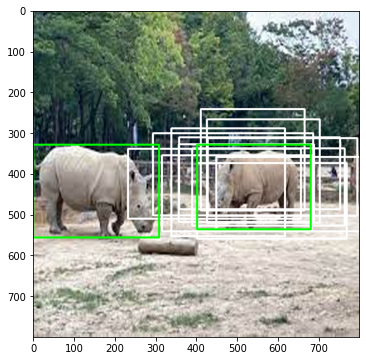

In [ ]:
# FOREGROUND
img_clone = np.copy(img)

for i in range(pos_roi_per_this_image):
  x1, y1, x2, y2 = roi[pos_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255,255,255),
                thickness=3)
  
for bbox in GroundTruth:
  cv2.rectangle(img_clone, (bbox[0], bbox[1]), (bbox[2], bbox[3]), 
                color = (0, 255, 0), thickness=3)

plt.figure(figsize=(9, 6))
plt.imshow(img_clone)
plt.show()

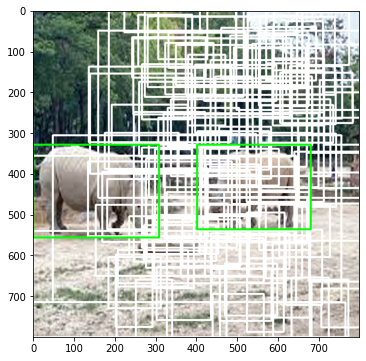

In [ ]:
# BACKGROUND
img_clone = np.copy(img)

plt.figure(figsize=(9, 6))

for i in range(neg_roi_per_this_image):
  x1, y1, x2, y2 = roi[neg_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 255, 255),
                thickness=3)
  
for bbox in GroundTruth:
  cv2.rectangle(img_clone, (bbox[0], bbox[1]), (bbox[2], bbox[3]), 
                color = (0, 255, 0), thickness=3)
  
plt.imshow(img_clone)
plt.show()

### Gather POS/NEG samples

In [ ]:
keep_index = np.append(pos_index, neg_index)
print("keep_index size:",keep_index.shape)

gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0 # negative labels => 0
sample_roi = roi[keep_index]
print("\ngt_roi_labels Values:",gt_roi_labels[:10])
print("sample_roi Values:",sample_roi[:10])

keep_index size: (128,)

gt_roi_labels Values: [1 1 1 1 1 1 1 1 1 1]
sample_roi Values: [[410.68294907 242.70511627 664.99952316 490.62195587]
 [448.24077258 359.39909076 800.         541.86123273]
 [427.2863657  313.97904459 793.77099745 503.10479618]
 [401.68109123 374.63265672 767.60427571 559.35245634]
 [315.21652938 355.06820469 682.8254799  541.30530163]
 [232.86748281 339.91658962 655.71535267 510.39630568]
 [389.9294821  338.11167555 762.15387533 527.95182768]
 [338.8909502  289.64717484 616.30138111 553.82689285]
 [356.62922693 328.02645916 687.33867497 518.0805905 ]
 [425.59730721 267.04991162 701.04252815 520.69252026]]


In [ ]:
# GroundTruth와의 IOU를 바탕으로 인덱스와 그 값을 추출한 변수 gt_assignment
bbox_for_sampled_roi = GroundTruth[gt_assignment[keep_index]]
print("gt_assignment[keep_index]: \n", gt_assignment[keep_index])
print("\nbbox_for_sampled_roi shape: ", bbox_for_sampled_roi.shape)
print("bbox_for_sampled_roi: \n", bbox_for_sampled_roi[:10])

gt_assignment[keep_index]: 
 [1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1
 1 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0
 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1]

bbox_for_sampled_roi shape:  (128, 4)
bbox_for_sampled_roi: 
 [[401 329 679 536]
 [401 329 679 536]
 [401 329 679 536]
 [401 329 679 536]
 [401 329 679 536]
 [401 329 679 536]
 [401 329 679 536]
 [401 329 679 536]
 [401 329 679 536]
 [401 329 679 536]]


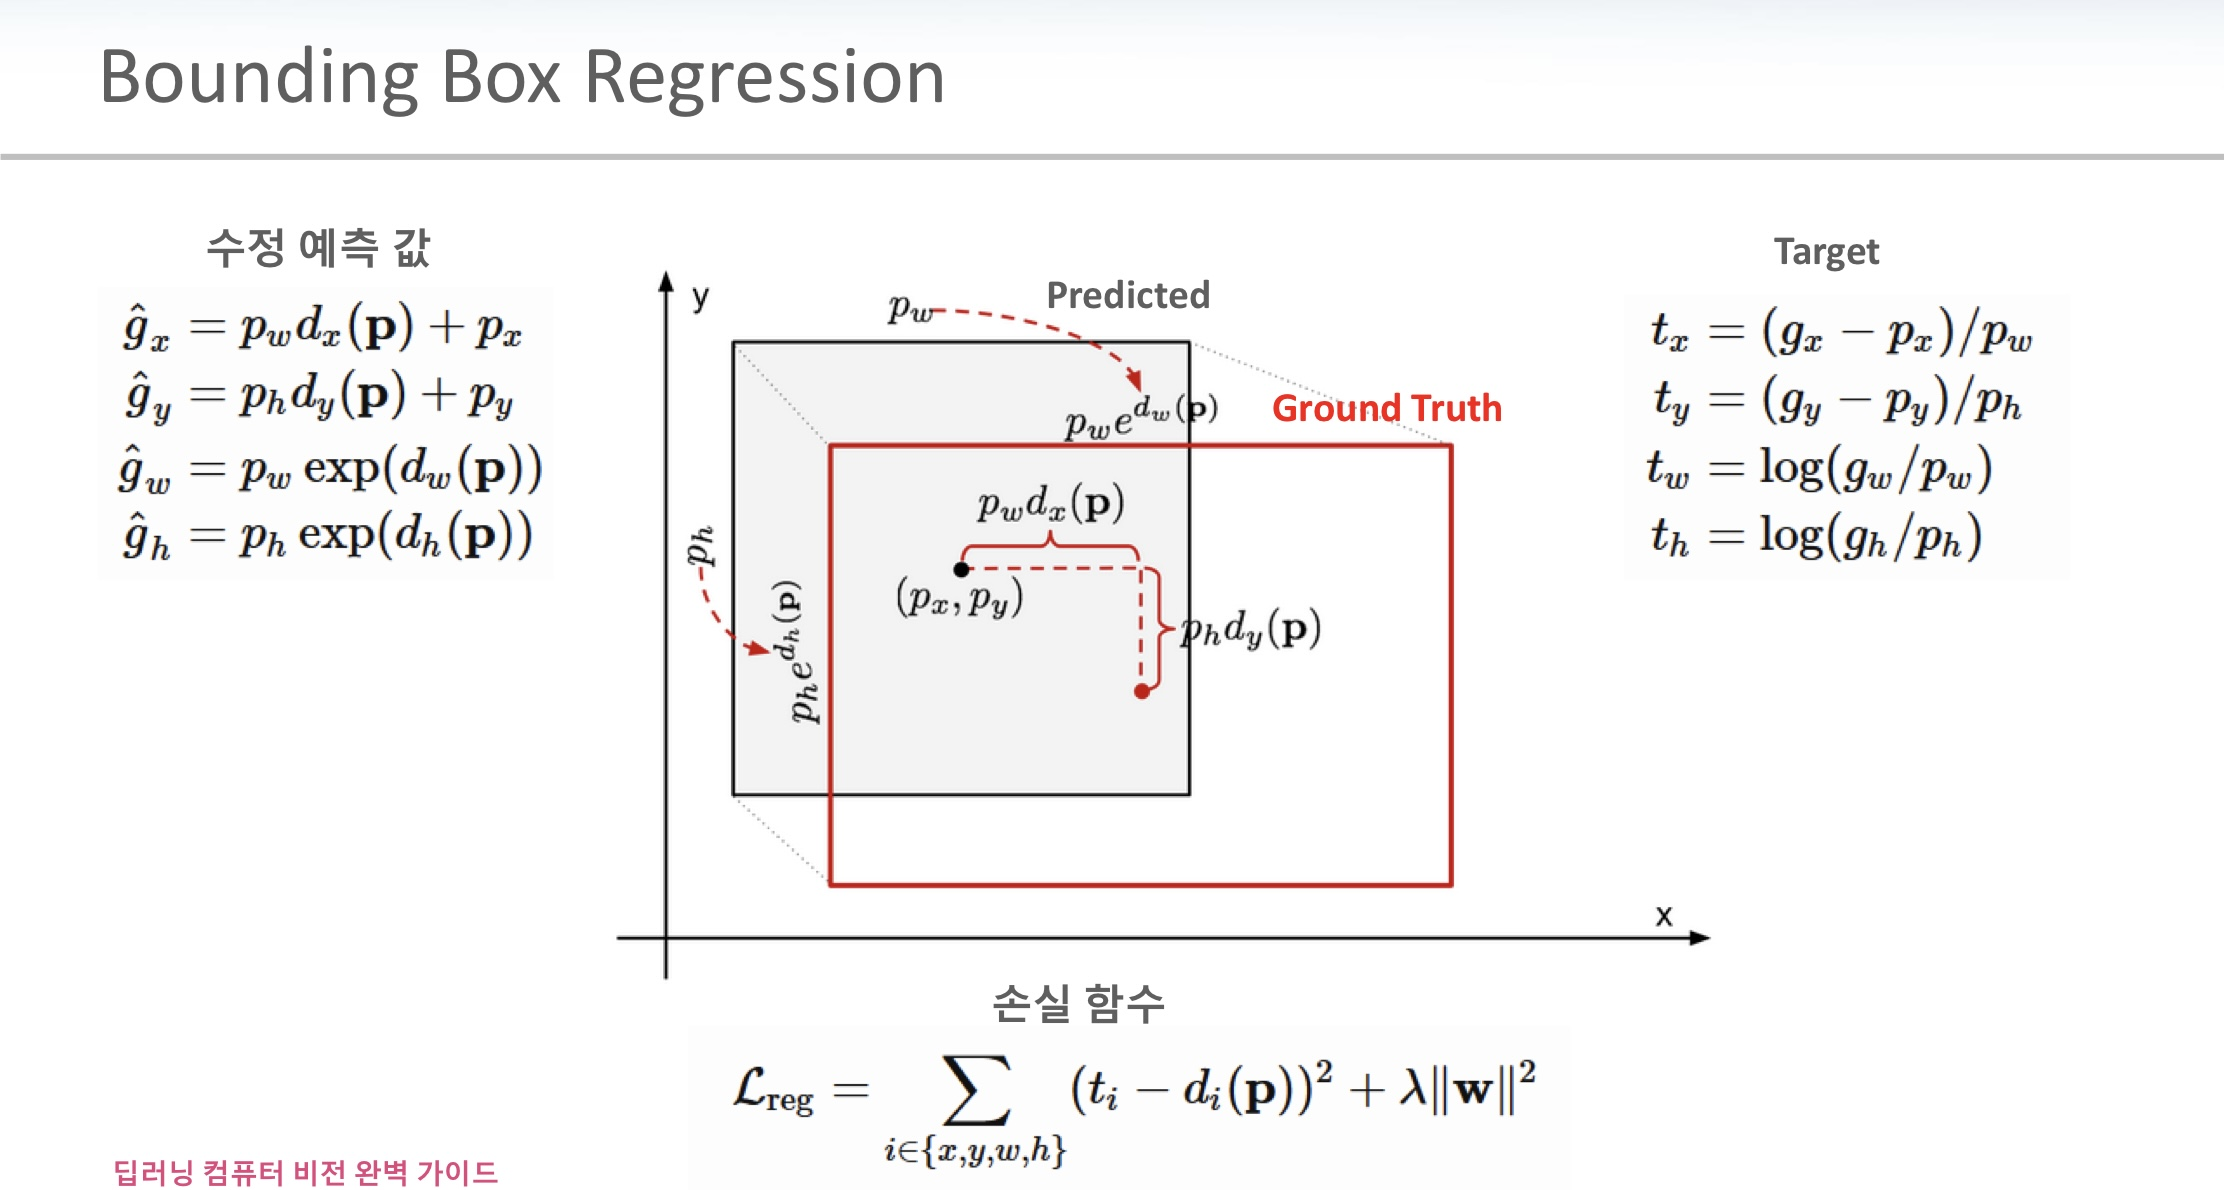

In [ ]:
# bbox_for_sampled_roi 와 sample_roi로 anchor box화로 값을 변경해줌 
width = sample_roi[:, 2] - sample_roi[:, 0]
height = sample_roi[:, 3] - sample_roi[:, 1]
ctr_x = sample_roi[:, 0] + 0.5 * width
ctr_y = sample_roi[:, 1] + 0.5 * height

base_width = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_height = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_x = bbox_for_sampled_roi[:, 0] + 0.5 * base_width
base_ctr_y = bbox_for_sampled_roi[:, 1] + 0.5 * base_height

In [ ]:
# transform anchor boxes

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dx = (base_ctr_x - ctr_x) / width
dy = (base_ctr_y - ctr_y) / height
dw = np.log(base_width / width)
dh = np.log(base_height / height)

gt_roi_locs = np.vstack((dx, dy, dw, dh)).transpose()

print("gt_roi_locs shape:",gt_roi_locs.shape)
print("gt_roi_locs Values: \n",gt_roi_locs[:10])

gt_roi_locs shape: (128, 4)
gt_roi_locs Values: 
 [[ 0.00848849  0.26555866  0.08904127 -0.18037457]
 [-0.23914195 -0.09936396 -0.23532581  0.12617608]
 [-0.19244649  0.12667804 -0.27633547  0.09030665]
 [-0.12200015 -0.18672907 -0.27480232  0.11387871]
 [ 0.11147442 -0.08423001 -0.27939863  0.10569822]
 [ 0.22634283  0.04307581 -0.41939135  0.19410247]
 [-0.09682783 -0.00280105 -0.29187577  0.08653638]
 [ 0.22495129  0.04074108  0.002123   -0.24391083]
 [ 0.05447697  0.04970413 -0.17361908  0.08540986]
 [-0.08466263  0.15229612  0.00923234 -0.20320743]]


# 8) ROI Pooling

### Concatenate labels with bbox coordinates

In [ ]:
rois = torch.from_numpy(sample_roi).float()
print("rois shape:",rois.shape)

roi_indices = np.zeros((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print("\nroi_indices shape:",roi_indices.shape)
print("roi_indices Values: \n",roi_indices)

rois shape: torch.Size([128, 4])

roi_indices shape: torch.Size([128])
roi_indices Values: 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


In [ ]:
indices_and_rois = torch.cat([roi_indices[:,None], rois], dim=1)
print("indices_and_rois shape:",indices_and_rois.shape)
print("indices_and_rois Values: \n",indices_and_rois[:10])

# xy좌표 변
xy_indices_and_rois = indices_and_rois[:,[0,2,1,4,3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print("\nindices_and_rois shape:",indices_and_rois.shape)
print("indices_and_rois Values: \n",indices_and_rois[:10])

indices_and_rois shape: torch.Size([128, 5])
indices_and_rois Values: 
 tensor([[  0.0000, 410.6830, 242.7051, 664.9995, 490.6219],
        [  0.0000, 448.2408, 359.3991, 800.0000, 541.8612],
        [  0.0000, 427.2864, 313.9790, 793.7710, 503.1048],
        [  0.0000, 401.6811, 374.6327, 767.6042, 559.3525],
        [  0.0000, 315.2165, 355.0682, 682.8255, 541.3053],
        [  0.0000, 232.8675, 339.9166, 655.7153, 510.3963],
        [  0.0000, 389.9295, 338.1117, 762.1539, 527.9518],
        [  0.0000, 338.8910, 289.6472, 616.3014, 553.8269],
        [  0.0000, 356.6292, 328.0265, 687.3387, 518.0806],
        [  0.0000, 425.5973, 267.0499, 701.0425, 520.6925]])

indices_and_rois shape: torch.Size([128, 5])
indices_and_rois Values: 
 tensor([[  0.0000, 242.7051, 410.6830, 490.6219, 664.9995],
        [  0.0000, 359.3991, 448.2408, 541.8612, 800.0000],
        [  0.0000, 313.9790, 427.2864, 503.1048, 793.7710],
        [  0.0000, 374.6327, 401.6811, 559.3525, 767.6042],
        [  0.0

### ROI Pooling

In [ ]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [ ]:
# torch.narrow(dim, start, end)
# x[begin:end] 와 유
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # sub-sampling ratio
rois = rois.long()
num_rois = rois.size(0)
print("rois shape:",indices_and_rois.shape)
print("rois Values: \n",indices_and_rois[:10])


output = []

for i in range(num_rois):
  roi = rois[i]
  im_idx = roi[0]
  im = output_map.narrow(0, im_idx, 1)[..., roi[1]:(roi[3]+1), roi[2]:(roi[4]+1)]
  tmp = adaptive_max_pool(im)
  output.append(tmp[0])

output = torch.cat(output, 0)
print("output shape:",output.shape)

rois shape: torch.Size([128, 5])
rois Values: 
 tensor([[0.0000e+00, 5.3891e-14, 9.1190e-14, 1.0894e-13, 1.4766e-13],
        [0.0000e+00, 7.9803e-14, 9.9529e-14, 1.2032e-13, 1.7764e-13],
        [0.0000e+00, 6.9717e-14, 9.4877e-14, 1.1171e-13, 1.7625e-13],
        [0.0000e+00, 8.3185e-14, 8.9191e-14, 1.2420e-13, 1.7044e-13],
        [0.0000e+00, 7.8841e-14, 6.9992e-14, 1.2019e-13, 1.5162e-13],
        [0.0000e+00, 7.5477e-14, 5.1707e-14, 1.1333e-13, 1.4560e-13],
        [0.0000e+00, 7.5076e-14, 8.6582e-14, 1.1723e-13, 1.6923e-13],
        [0.0000e+00, 6.4315e-14, 7.5249e-14, 1.2297e-13, 1.3685e-13],
        [0.0000e+00, 7.2837e-14, 7.9188e-14, 1.1504e-13, 1.5262e-13],
        [0.0000e+00, 5.9297e-14, 9.4502e-14, 1.1562e-13, 1.5566e-13]])
output shape: torch.Size([128, 512, 7, 7])


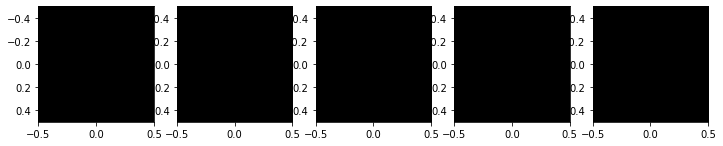

In [ ]:
# Visualization ROI feature maps
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = output_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    
    figNo +=1
plt.show()

In [ ]:
# Reshape the output that we can pass it through the Faster RCNN layer
k = output.view(output.shape[0], -1)
print("k shape:",k.shape)

k shape: torch.Size([128, 25088])


# 9) Faster RCNN

### Classifier and Bbox Regressor

In [ ]:
roi_head_classifier = nn.Sequential(*[
                    nn.Linear(25088, 4096),
                    nn.Linear(4096, 4096)]).to(device)
                    
# 1 class / 1 background * 4 coordinates
cls_loc = nn.Linear(4096, 2*4).to(device)
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

 # 1 class / 1 background
score = nn.Linear(4096, 2).to(device)

In [ ]:
k = roi_head_classifier(k.to(device))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)

print("roi_cls_loc shape:",roi_cls_loc.shape)
print("roi_cls_loc values:",roi_cls_loc[:10])

print("\nroi_cls_score shape:",roi_cls_score.shape)
print("roi_cls_score values:",roi_cls_score[:10])

roi_cls_loc shape: torch.Size([128, 8])
roi_cls_loc values: tensor([[ 0.0174,  0.1212, -0.0008, -0.0190, -0.0114,  0.0056, -0.0821, -0.0774],
        [ 0.0174,  0.1212, -0.0008, -0.0190, -0.0114,  0.0056, -0.0821, -0.0774],
        [ 0.0174,  0.1212, -0.0008, -0.0190, -0.0114,  0.0056, -0.0821, -0.0774],
        [ 0.0174,  0.1212, -0.0008, -0.0190, -0.0114,  0.0056, -0.0821, -0.0774],
        [ 0.0174,  0.1212, -0.0008, -0.0190, -0.0114,  0.0056, -0.0821, -0.0774],
        [ 0.0174,  0.1212, -0.0008, -0.0190, -0.0114,  0.0056, -0.0821, -0.0774],
        [ 0.0174,  0.1212, -0.0008, -0.0190, -0.0114,  0.0056, -0.0821, -0.0774],
        [ 0.0174,  0.1212, -0.0008, -0.0190, -0.0114,  0.0056, -0.0821, -0.0774],
        [ 0.0174,  0.1212, -0.0008, -0.0190, -0.0114,  0.0056, -0.0821, -0.0774],
        [ 0.0174,  0.1212, -0.0008, -0.0190, -0.0114,  0.0056, -0.0821, -0.0774]],
       grad_fn=<SliceBackward>)

roi_cls_score shape: torch.Size([128, 2])
roi_cls_score values: tensor([[ 0.0924, -0.0

In [ ]:
print("gt_roi_locs shape:", gt_roi_locs.shape)
print("gt_roi_labels shape:", gt_roi_labels.shape)

gt_roi_locs shape: (128, 4)
gt_roi_labels shape: (128,)


### Classification loss

In [ ]:
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)
print("Classification loss:",roi_cls_loss)

torch.Size([128, 4]) torch.Size([128])
Classification loss: tensor(0.6423, grad_fn=<NllLossBackward>)


### Regressor loss

In [ ]:
n_sample = roi_cls_loc.shape[0] # 128
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

torch.Size([128, 2, 4])


In [ ]:
roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

torch.Size([128, 4])


In [ ]:
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)

print("mask shape:",mask.shape)
print("mask values:",mask[:10])

mask shape: torch.Size([128, 4])
mask values: tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])


In [ ]:
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(roi_loc_loss.sum())

torch.Size([24, 4]) torch.Size([24, 4])
tensor(0.8813, dtype=torch.float64, grad_fn=<SumBackward0>)


### Multi task loss

In [ ]:
roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)

total_loss = rpn_loss + roi_loss
print(total_loss)

tensor([[0.6512, 0.6522, 0.8092, 0.7516],
        [0.6524, 0.6436, 0.8099, 0.7408],
        [0.6559, 0.6662, 0.8170, 0.7358],
        [0.6430, 0.6598, 0.8041, 0.7406],
        [0.6432, 0.6424, 0.8040, 0.7213],
        [0.6426, 0.6623, 0.8040, 0.7228],
        [0.6737, 0.6594, 0.7919, 0.7584],
        [0.6699, 0.6424, 0.7848, 0.7331],
        [0.6710, 0.6645, 0.7802, 0.7288],
        [0.7352, 0.6519, 0.7981, 0.7596],
        [0.7333, 0.6446, 0.7682, 0.7372],
        [0.7330, 0.6785, 0.7342, 0.7486],
        [0.6746, 0.7238, 0.6815, 1.0411],
        [0.6838, 0.6826, 0.6735, 1.0103],
        [0.6874, 0.6536, 0.6660, 1.0858],
        [0.7185, 0.6440, 0.6759, 1.0578],
        [0.6423, 0.7364, 0.6736, 0.8604],
        [0.6424, 0.6701, 0.6668, 0.9547],
        [0.6427, 0.6424, 0.6555, 1.0439],
        [0.6535, 0.6486, 0.6834, 1.1233],
        [0.6660, 0.7048, 0.6424, 0.9022],
        [0.6745, 0.6476, 0.6534, 0.9719],
        [0.6480, 0.6502, 0.6611, 1.0227],
        [0.6436, 0.6685, 0.6847, 0

## Refeerence
* https://github.com/herbwood/pytorch_faster_r_cnn/blob/main/faster_r_cnn.ipynb